# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Plot Ground Truth Bounding Boxes</h3></td> <td><h3>20</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Training</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Inference</h3></td> <td><h3>15</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>COCO Detection Evaluation</h3></td> <td><h3>25</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Run Inference on a Video</h3></td> <td><h3>15</h3></td> </tr>
    </table>
</div>


# <font style="color:purple">Download the Dataset</font> 

**[Download the Vehicle registration plate](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1)**


Download the Vehicle Registration Plate dataset from [here](https://www.dropbox.com/s/k81ljpmzy3fgtx9/Dataset.zip?dl=1) and unzip it. 

We will have the following directory structure:

```
Dataset
├── train
│   └── Vehicle registration plate
│       └── Label
└── validation
    └── Vehicle registration plate
        └── Label
```

Unzipping the file will give you a directory `Dataset`. This directory has two folder `train` and `validation`. Each train and validation folder has `Vehicle registration plate`  folder with `.jpg` images and a folder `Labels`.  `Labels` folder has bounding box data for the images.


For example,
For image: `Dataset/train/Vehicle registration plate/bf4689922cdfd532.jpg`
Label file is  `Dataset/train/Vehicle registration plate/Label/bf4689922cdfd532.txt`

There are one or more lines in each `.txt` file. Each line represents one bounding box.
For example,
```
Vehicle registration plate 385.28 445.15 618.24 514.225
Vehicle registration plate 839.68 266.066462 874.24 289.091462
```

We have a single class detection (`Vehicle registration plate detection`) problem. So bounding box details start from the fourth column in each row.

Representation is in `xmin`, `ymin`, `xmax`, and `ymax` format.

**It has `5308` training and `386` validation dataset.**

Data is downloaded from [Open Images Dataset](https://storage.googleapis.com/openimages/web/index.html)

In [1]:
import os
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb=512'

import torch
torch.cuda.set_per_process_memory_fraction(0.75)

import glob
import cv2
from tqdm import tqdm

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
import torchvision

from torchvision import datasets, transforms

import pandas as pd

import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

import albumentations as A
from albumentations.pytorch import ToTensorV2


os.environ['KMP_DUPLICATE_LIB_OK']='True'


## Dataset

In [2]:
class PlateDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, transforms = None, train:bool = True):
        self.root = root
        self.transforms = transforms
        
        if train:
            self.images_dir = os.path.join(root,'train','Vehicle registration plate')
        else:
            self.images_dir = os.path.join(root,'validation','Vehicle registration plate')
        self.labels_dir = os.path.join(self.images_dir, 'Label')        
        
        self.images = list(sorted(glob.glob(f'{self.images_dir}/*.jpg')))
        self.labels = list(sorted(glob.glob(f'{self.labels_dir}/*.txt')))
        
        assert len(self.images) == len( self.labels), 'Images and Labels samples dont match' 
        
        
    def __getitem__(self, idx):
        #image = read_image(self.images[idx])
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        df = pd.read_csv(self.labels[idx], header=None, sep=' ')
        
        num_objs = df.shape[0]
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        
        #img = tv_tensors.Image(image)
        img = image/255
        
        boxes = []
        labels = []
        areas = []
        for r in range(df.shape[0]):
            boxes.append([df.iloc[r][3], df.iloc[r][4], df.iloc[r][5], df.iloc[r][6]])
            labels.append([1])
            areas.append((boxes[r][3] - boxes[r][1]) * (boxes[r][2] - boxes[r][0]))
                    
        #boxes = df.iloc[:, 3:]        
        #area = (boxes.iloc[:, 3] - boxes.iloc[:, 1]) * (boxes.iloc[:, 2] - boxes.iloc[:, 0])        
        
        target = {}
        target["boxes"] =  torch.as_tensor(boxes, dtype=torch.float32) # tv_tensors.BoundingBoxes(boxes.values, format="XYXY", canvas_size=F.get_size(F.to_tensor(img)))
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
        target["image_id"] = torch.tensor([idx])
        target["area"] = torch.as_tensor(areas, dtype=torch.float32) # area.values
        
       
        if self.transforms is not None:
            #print('image', type(img), len(ll), ll)
            transformed = self.transforms(image=img, bboxes=target["boxes"], class_labels=target["labels"] )
            img = transformed['image']
            target["boxes"] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            # Certifique-se de converter os rótulos novamente para int64 após as transformações
            target["labels"] = torch.as_tensor(transformed['class_labels'], dtype=torch.int64)
            
        return img, target
    
    def __len__(self):
        return len(self.images)


In [3]:
a = PlateDataset('Dataset', None, True)

In [4]:
aa, bb = a.__getitem__(0)

In [5]:
for key, value in bb.items():
    print(type(key), type(value))
    print(key, value, '\n')    

<class 'str'> <class 'torch.Tensor'>
boxes tensor([[ 471.0400,  602.6677,  513.2800,  623.1407],
        [1007.3600,  519.4971, 1021.4400,  532.2928]]) 

<class 'str'> <class 'torch.Tensor'>
labels tensor([[1],
        [1]]) 

<class 'str'> <class 'torch.Tensor'>
image_id tensor([0]) 

<class 'str'> <class 'torch.Tensor'>
area tensor([864.7778, 180.1632]) 



In [6]:
bb['area']

tensor([864.7778, 180.1632])

### Auxiliars

In [7]:
class_labels  = [0, 1]

In [8]:
def image_preprocess_transforms():
    transform = A.Compose([
        A.LongestMaxSize(max_size=256),
        A.PadIfNeeded(256,256),
        #A.HorizontalFlip(p=0.5),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))
    
    return transform

In [9]:
def collate_fn(data):
    return tuple(zip(*data))

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 

**You have to show three images from validation data with the bounding boxes.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-g3.png'>



In [10]:
a = PlateDataset('Dataset', image_preprocess_transforms(), True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


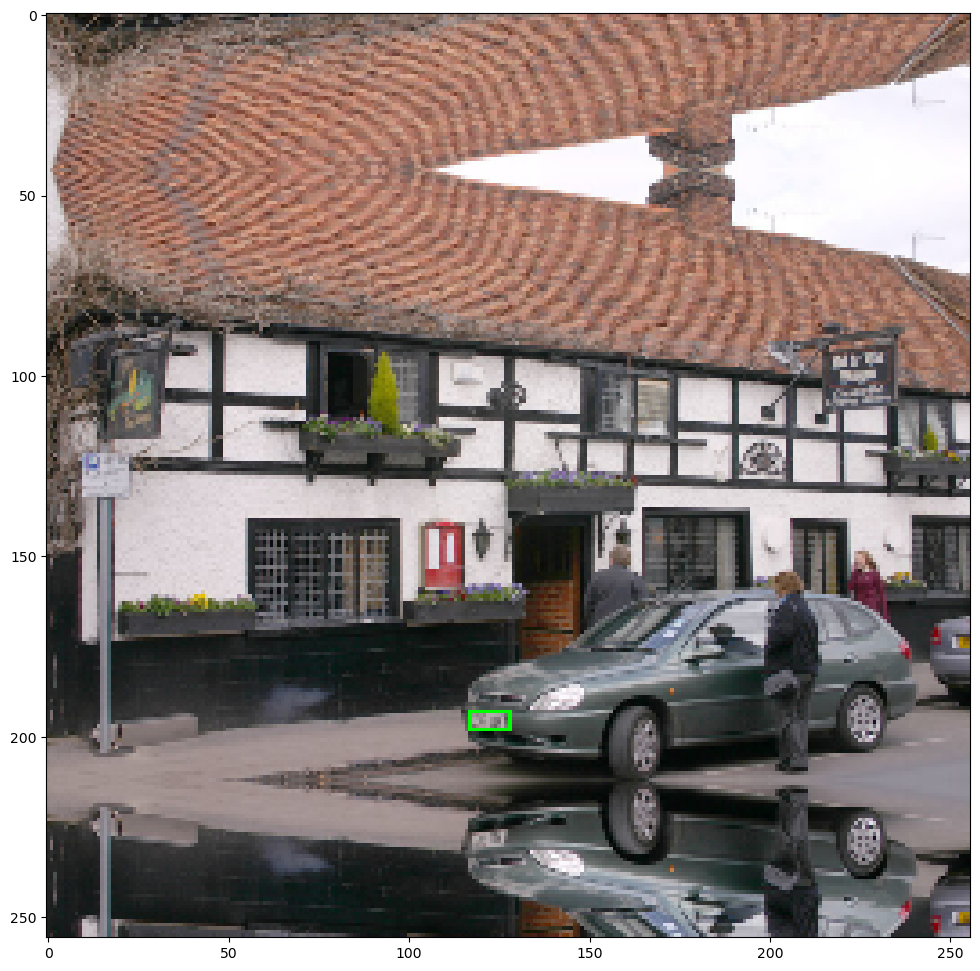

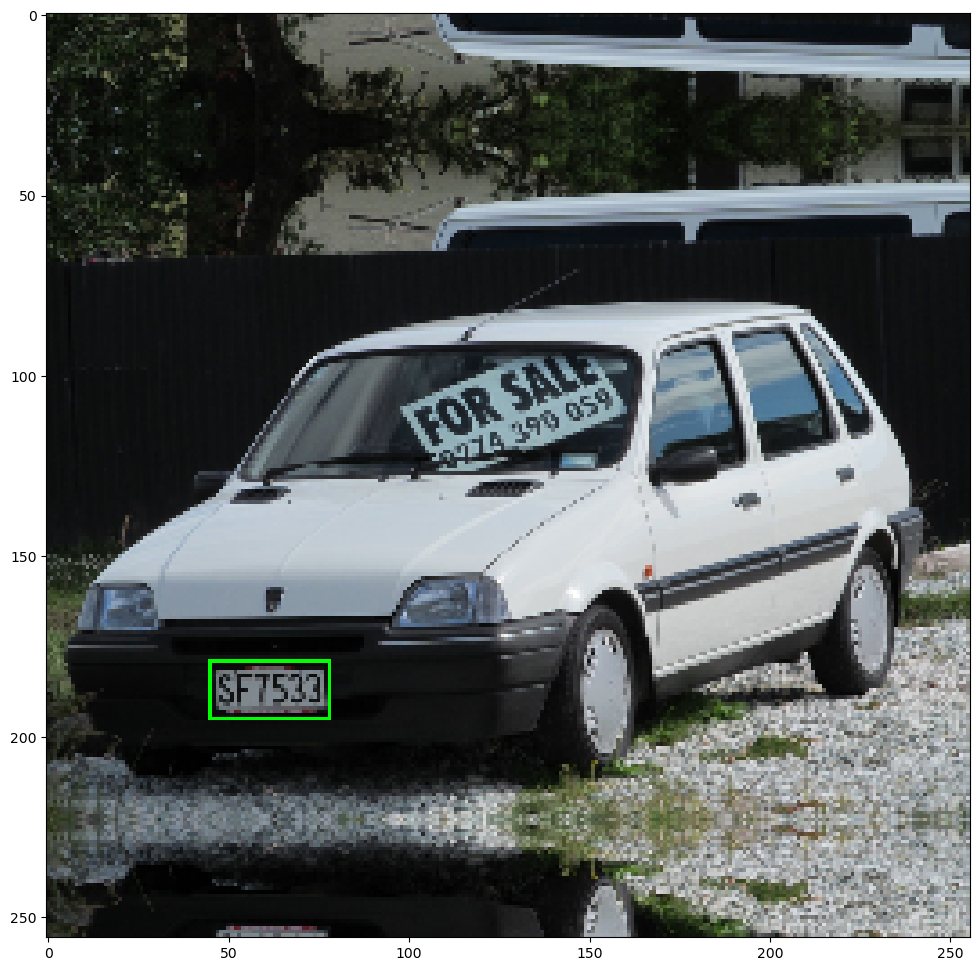

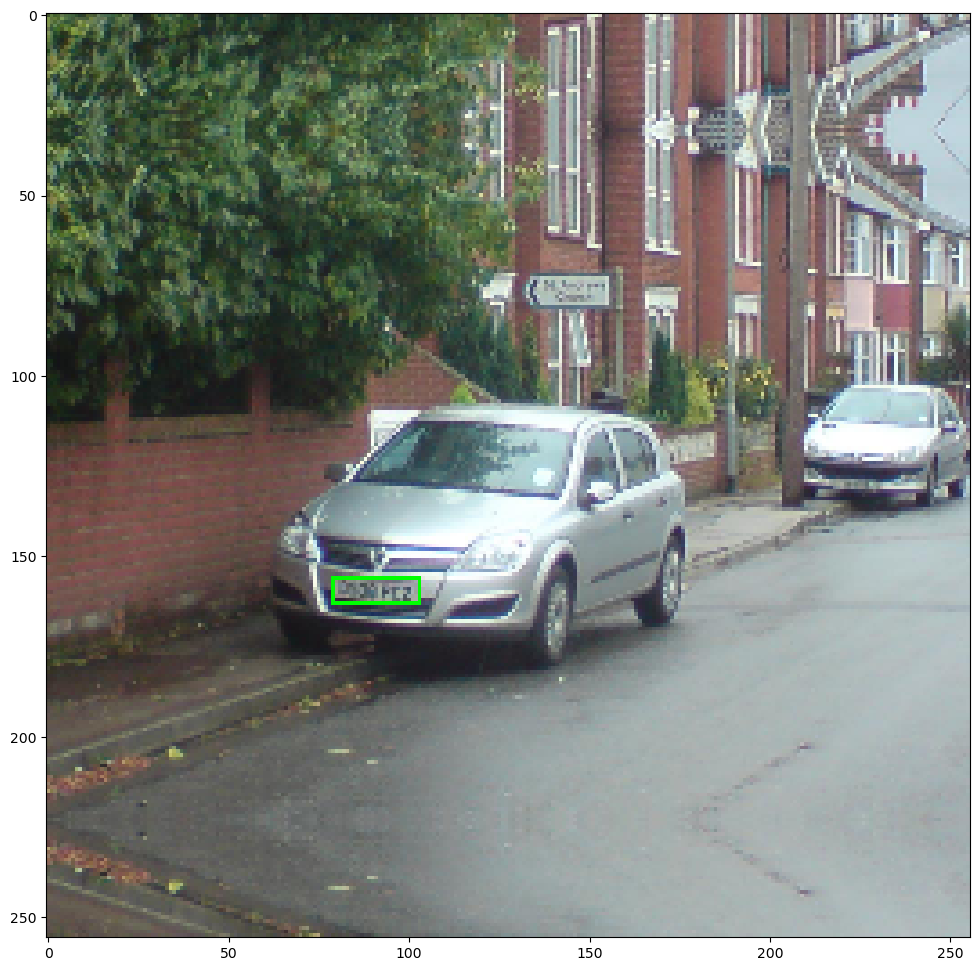

In [11]:
for i in range(3):
    images, targets = a.__getitem__(i)
    #print(targets)
      
    pred_boxes = targets["boxes"] #.long()
    
    #output_image = draw_bounding_boxes(images, pred_boxes,  colors="red")
    cv2.rectangle(images.numpy().transpose(1, 2, 0), (int(pred_boxes[0][0]), int(pred_boxes[0][1])),(int(pred_boxes[0][2]), int(pred_boxes[0][3])), (0,255,0) )
    
    plt.figure(figsize=(12, 12))
    plt.imshow(images.permute(1, 2, 0))

    

#  <font style="color:green">2. Training [25 Points]</font> 

- **Write your training code in this section.**

- **You also have to share ([shared logs example](https://tensorboard.dev/experiment/JRtnsKbwTaq1ow6nPLPGeg)) the loss plot of your training using tensorboard.dev.** 

How to share TensorBoard logs using tensorboard.dev find [here](https://courses.opencv.org/courses/course-v1:OpenCV+OpenCV-106+2019_T1/courseware/b1c43ffe765246658e537109e188addb/d62572ec8bd344db9aeae81235ede618/4?activate_block_id=block-v1%3AOpenCV%2BOpenCV-106%2B2019_T1%2Btype%40vertical%2Bblock%40398b46ddcd5c465fa52cb4d572ba3229).

### Model

In [12]:
def get_object_detection_model(num_classes):
    from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
    
    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

### Dataloaders

In [13]:
train_dataloader = torch.utils.data.DataLoader(PlateDataset('Dataset', image_preprocess_transforms(), True), 1, shuffle=True, collate_fn=collate_fn)

In [14]:
test_dataloader = torch.utils.data.DataLoader(PlateDataset('Dataset', image_preprocess_transforms(), False), 1, shuffle=False, collate_fn=collate_fn)

In [15]:
print(len(train_dataloader), len(test_dataloader))

5308 386


### Settings

In [16]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')
num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

model = torch.nn.DataParallel(model)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

C:\Users\igor\anaconda3\envs\AIVI\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\igor\anaconda3\envs\AIVI\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### training

In [17]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    train_loss_list = []

    tqdm_bar = tqdm(data_loader, total=len(data_loader))
    
    for idx, (images, targets) in enumerate(tqdm_bar):
        optimizer.zero_grad()

        images = list(image.to(device).to(torch.float32) for image in images)
                
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'=tensor, 'labels'=tensor}
        #for t in targets:
        #    for k, v in t.items():
        #        print('k', type(k), k)
         #       print('v', type(v), v.type(), v)
         #   break
            
        losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        train_loss_list.append(loss.detach().cpu().numpy())

        loss.backward()
        optimizer.step()

        tqdm_bar.set_description(desc=f"Training Loss: {loss:.3f}")

    return train_loss_list

In [18]:
def evaluate(model, data_loader_test, device):
    val_loss_list = []

    tqdm_bar = tqdm(data_loader_test, total=len(data_loader_test))

    for i, data in enumerate(tqdm_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        val_loss_list.append(loss_val)

        tqdm_bar.set_description(desc=f"Validation Loss: {loss:.4f}")
    return val_loss_list

In [19]:
# training for 10 epochs
num_epochs = 1

best_loss = 100


for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    print(f'-------- EPOCH  {epoch} -----------------')
    
    train_loss_list = train_one_epoch(model, optimizer, train_dataloader, device, epoch)
    print(type(train_loss_list), train_loss_list)
        
    lr_scheduler.step()
    
    valid_loss_list = evaluate(model, test_dataloader, device)
    
    
    current_loss = sum(valid_loss_list)
    if best_loss > current_loss:
        torch.save(model.state_dict(), 'best_loss.pth')
        best_loss = current_loss
    

-------- EPOCH  0 -----------------


  0%|                                                                                         | 0/5308 [00:00<?, ?it/s]C:\Users\igor\AppData\Local\Temp\ipykernel_18740\210096916.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'=tensor, 'labels'=tensor}
Training Loss: 1.108:   0%|                                                         | 1/5308 [00:04<7:10:33,  4.87s/it]C:\Users\igor\AppData\Local\Temp\ipykernel_18740\210096916.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'

OutOfMemoryError: CUDA out of memory. Tried to allocate 40.00 MiB. GPU 0 has a total capacty of 2.00 GiB of which 26.51 MiB is free. Of the allocated memory 919.15 MiB is allocated by PyTorch, and 72.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

#  <font style="color:green">3. Inference [15 Points]</font> 

**You have to make predictions from your trained model on three images from the validation dataset.**

The plotted images should be similar to the following:

<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p1.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p2.png'>



<img src='https://www.learnopencv.com/wp-content/uploads/2020/04/c3-w10-p3.png'>




#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 

**You have to evaluate your detection model on COCO detection evaluation metric.**

For your reference here is the coco evaluation metric chart:


---

<img src="https://www.learnopencv.com/wp-content/uploads/2020/03/c3-w9-coco_metric.png">

---

#### <font style="color:red">The expected `AP` (primary challenge metric) is more than `0.5`.</font>

**The expected output should look similar to the following:**

```
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.550
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.629
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.256
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.504
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.629
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.722
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.704
```



# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

#### [Download the Input Video](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1)

**You have to run inference on a video.** 

You can download the video from [here](https://www.dropbox.com/s/g88o4dx18zpgn8k/projet3-input-video.mp4?dl=1).

#### <font style="color:red">Upload the output video on youtube and share the link. Do not upload the video in the lab.</font>

In [ ]:
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("18HWHCevFdU", width=640, height=360)
display(video)

**Your output video should have a bounding box around the vehicle registration plate.**

In [ ]:
video = YouTubeVideo("5SgCuee7AMs", width=640, height=360)
display(video)

**You can use the following sample code to read and write a video.**

In [ ]:
def video_read_write(video_path):
    """
    Read video frames one-by-one, flip it, and write in the other video.
    video_path (str): path/to/video
    """
    video = cv2.VideoCapture(video_path)
    
    # Check if camera opened successfully
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    # create video writer
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    
    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])
    
    output_file = cv2.VideoWriter(
        filename=output_fname,
        # some installation of opencv may not support x264 (due to its license),
        # you can try other format (e.g. MPEG)
        fourcc=cv2.VideoWriter_fourcc(*"x264"),
        fps=float(frames_per_second),
        frameSize=(width, height),
        isColor=True,
    )
    
        
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if ret:
            
            output_file.write(frame[:, ::-1, :])
#             cv2.imwrite('anpd_out/frame_{}.png'.format(str(i).zfill(3)), frame[:, ::-1, :])
            i += 1
        else:
            break
        
    video.release()
    output_file.release()
    
    return